Laden der notwendigen Bibliotheken

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.image import AxesImage, NonUniformImage
import numpy as np
import math
from astropy.io import fits
from pathlib import Path
from scipy.signal import find_peaks
from slit import Slit

Festlegung der Dispersionsbeziehung aus determine_dispersion.ipynb als Polynom 1. Grades (Gerade)

In [2]:
#z = [5.16220206e-01, 3.93665555e+03]
z = [5.15438879e-01, 3.93984084e+03] # determined by compute_dispersion_picture and model picturemodel-20250721102214.h5


Definition des Pfades der Filterkurve

In [3]:
fits_name = 'Light_FILTER-10NM_1sec_Bin1_23.2C_gain0_2025-06-04_211719_frame0001.fit'
filter_name = fits_name.split('_')[1]
homepath = Path('.')
fits_path = homepath / '..' / 'data' / filter_name
fits_file = fits_path / fits_name

Einlesen der Fits Datei

In [4]:
with fits.open(str(fits_file)) as hdul:
    hdul.info()
    data = hdul[0].data

Filename: ../data/FILTER-10NM/Light_FILTER-10NM_1sec_Bin1_23.2C_gain0_2025-06-04_211719_frame0001.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (4944, 3284)   int16 (rescales to uint16)   


In [5]:
p = np.poly1d(z)
positions = range(0,data.shape[1],1)
waves = p(positions)

Auswahl eines Schnittes durch das Bild entlang der Dispersionsachse, bei Mitte der mittleren Slit-Position

full image


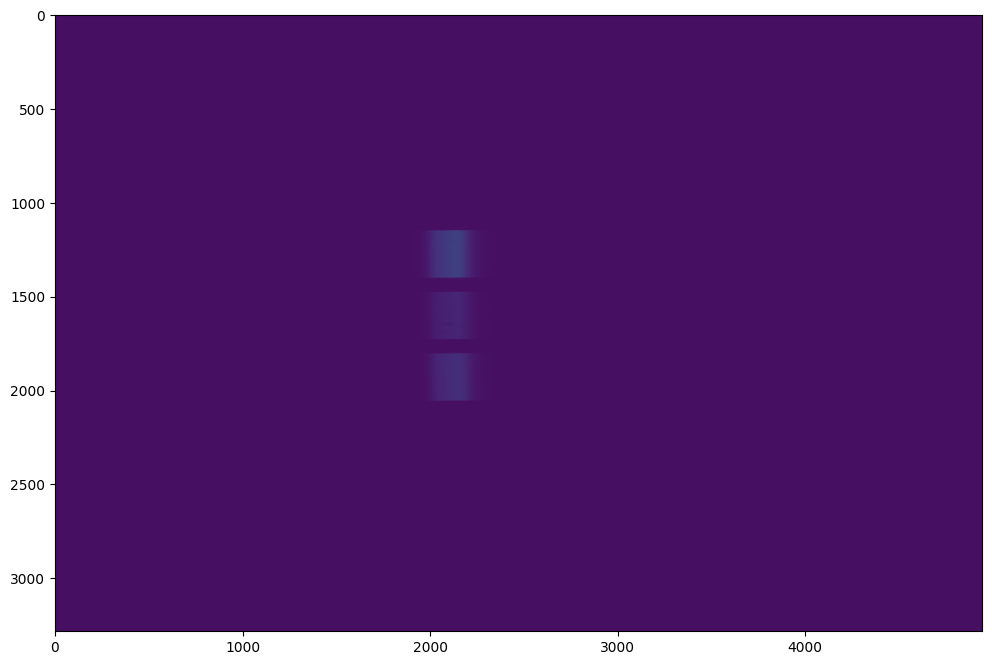

trace along columns


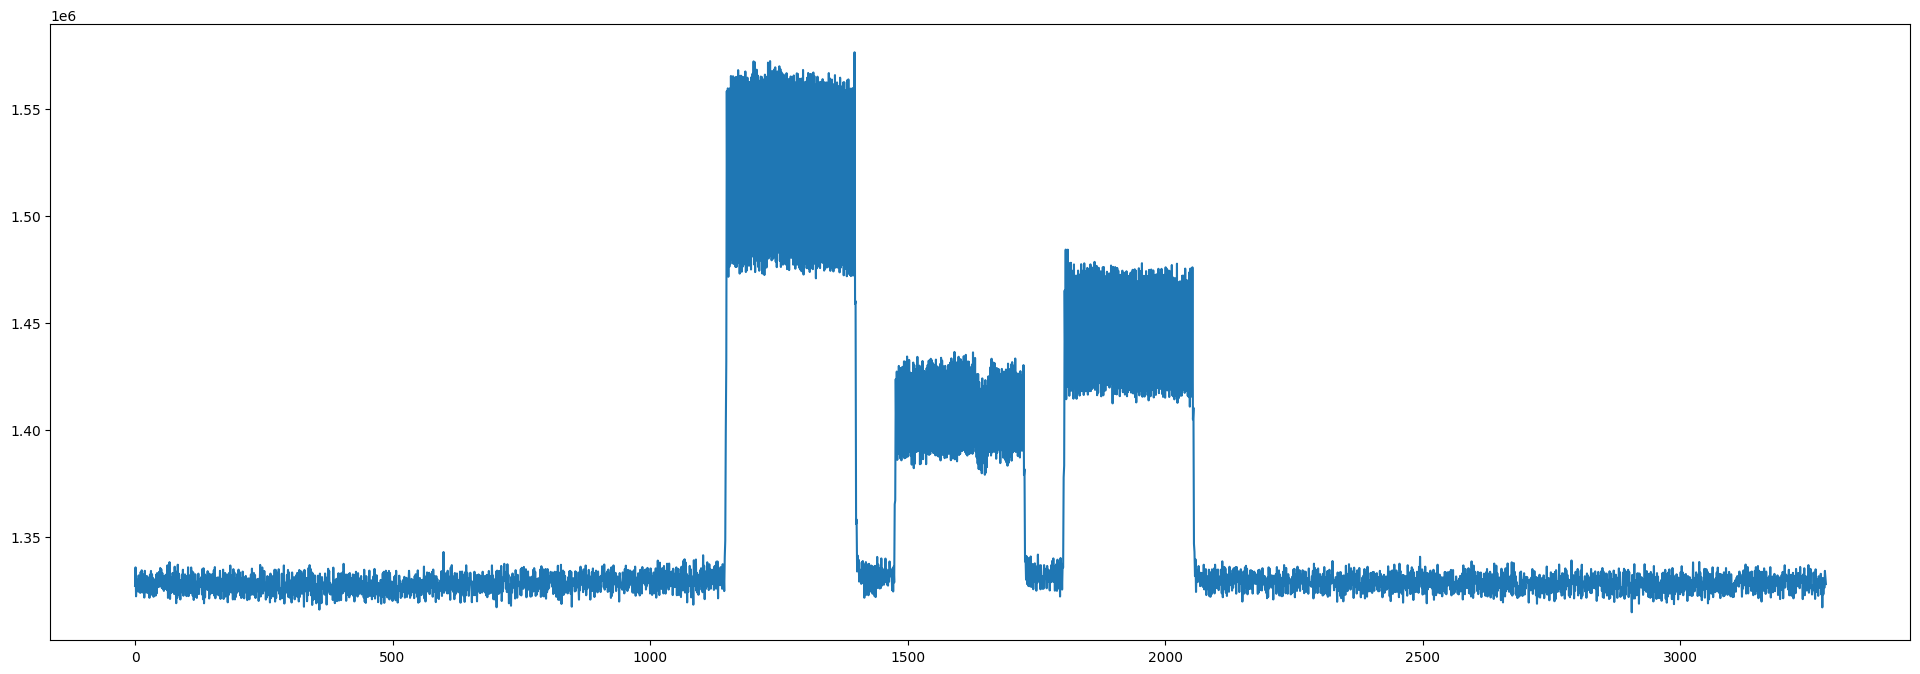

smoothed trace


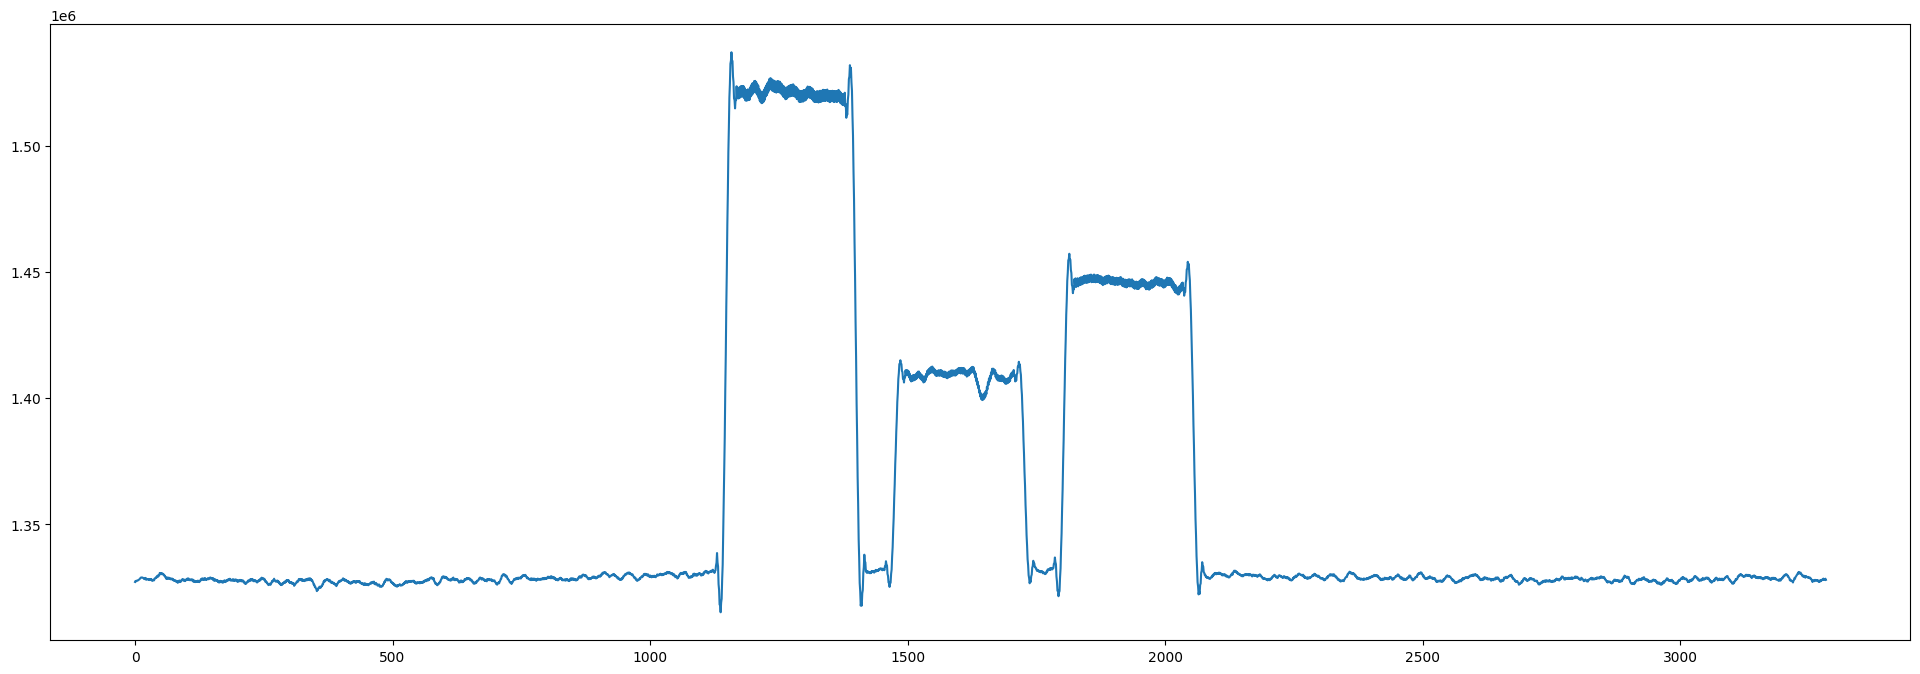

maximum positions of abs(1st derivative)


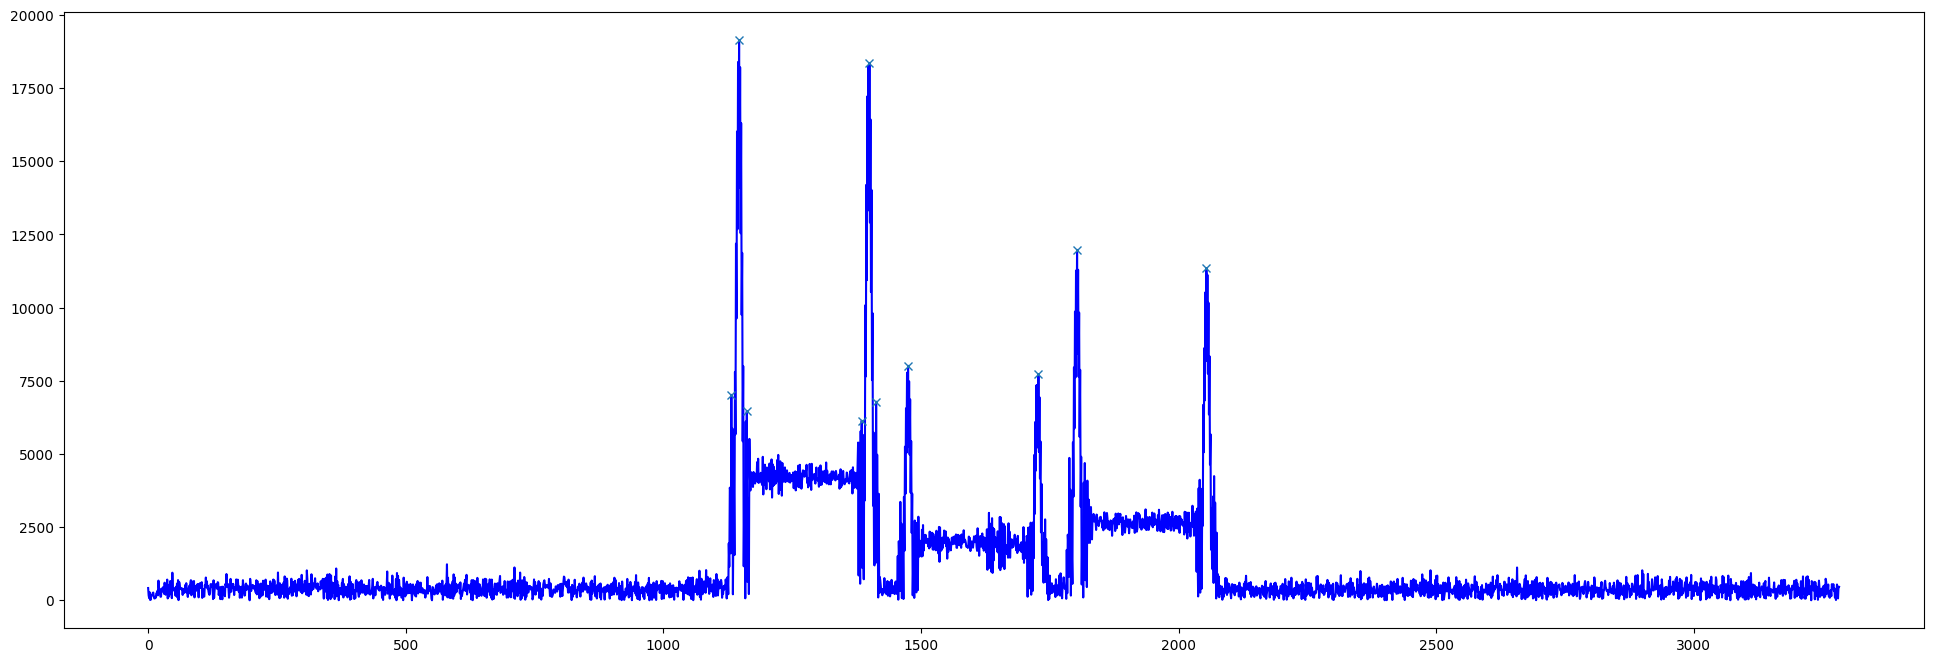

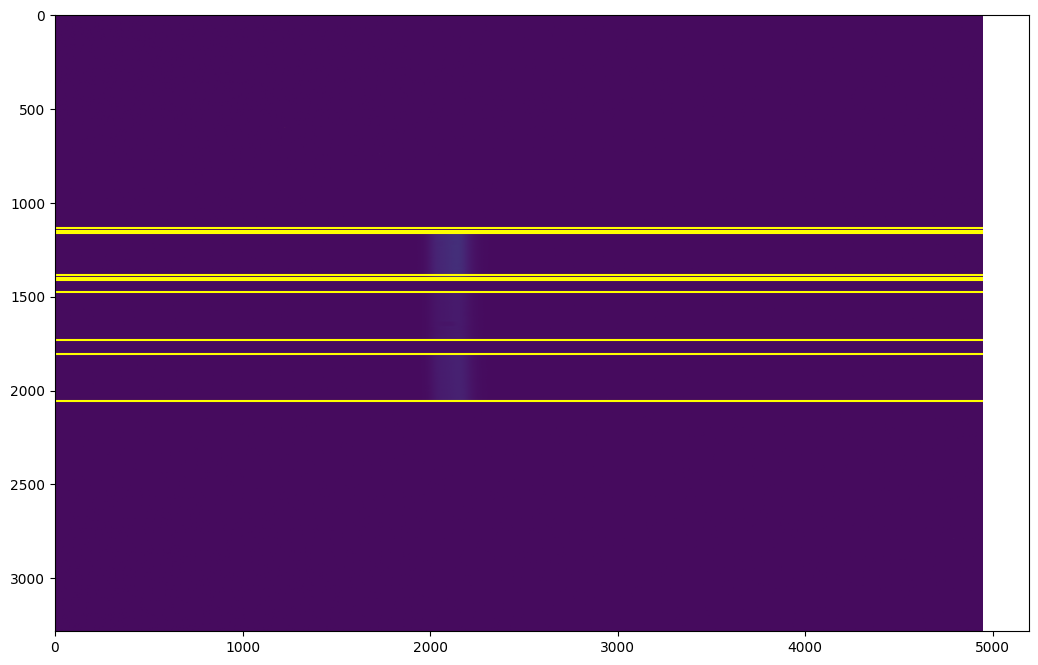

slit rows [1132 1147 1162 1385 1400 1413 1475 1728 1803 2054]
[1132 1147 1162 1385 1400 1413 1475 1728 1803 2054]


In [6]:
positions = Slit.determine_slit_rows(data, detection_level=0.3, distance=10) # detection_level 0...1
print (positions)

In [7]:
mid = int((positions[2]+positions[3])/2)
trace = data[mid,:]
trace_n = trace/max(trace)

Plot des Schnittes

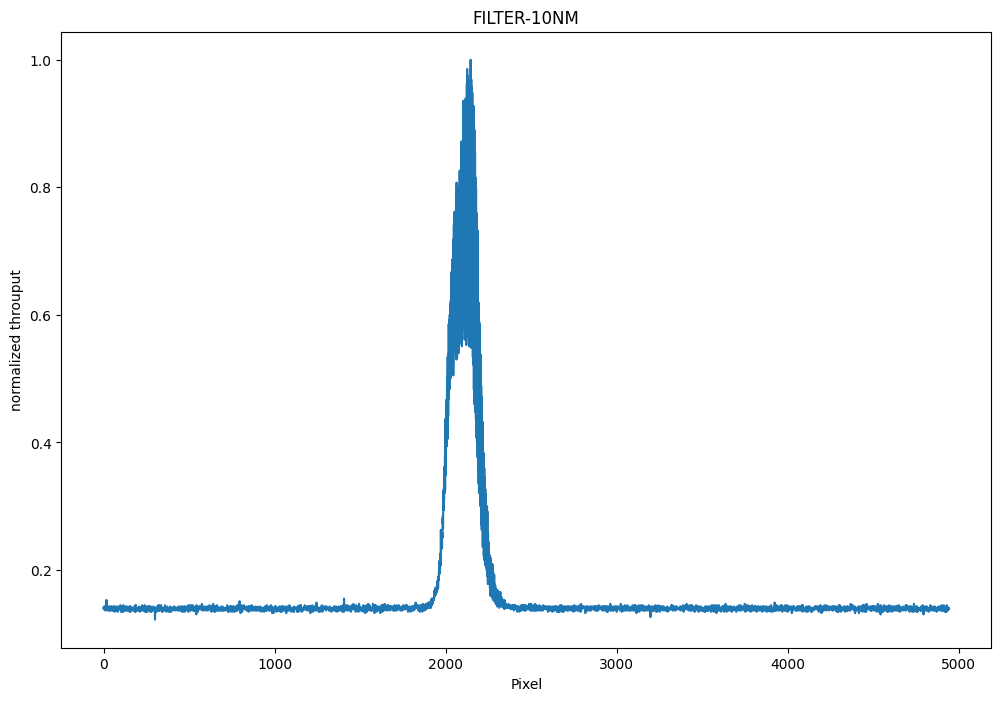

In [8]:
plt.rcParams['figure.figsize'] = (12,8)
fig, axes = plt.subplots()
plt.plot(trace_n)
plt.xlabel('Pixel')
plt.ylabel('normalized throuput')
plt.title(filter_name)
plt.show()

Plot des Schnittes, mit Wellenlängenzuordnung

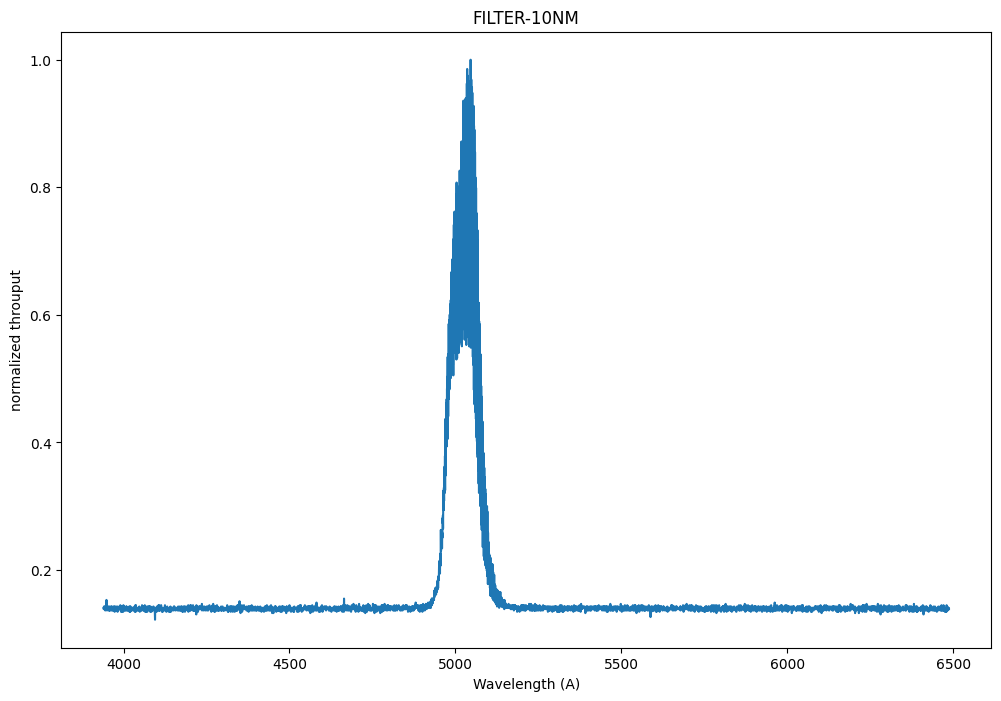

In [9]:
plt.rcParams['figure.figsize'] = (12,8)
fig, axes = plt.subplots()
plt.plot(waves,trace_n)
plt.xlabel('Wavelength (A)')
plt.ylabel('normalized throuput')
plt.title(filter_name)
plt.show()

Gesucht ist die Halbwertsbreite des Filters

Es wird ein Abschnitt aus dem Schnitt gemittelt: dieser Wert entspricht in etwa 
dem Untergrund ('dark'). Für die Bestimmung der Halbwertsbreite wird die Breite 
des Filterprofiles gemessen, die der halben Intensität - dark entspricht.

In [10]:
dark = np.mean(trace_n[100:500])
half_intensity = (1-dark)/2+dark

numerische Bestimmung der Halbwertsbreite

Finde alle Positionen des Schnitts, deren Wert größer als die "half_intensity" ist. 
Die Halbwertsbreite ist dann die Differenz zwischen der gefundenen maximalen und 
minimalen Position

In [11]:
positions_above_half = np.argwhere(trace_n > half_intensity)
fwhm_pos_min = positions_above_half[0][0]
fwhm_pos_max = positions_above_half[-1][0]
fwhm_wave_min = p(fwhm_pos_min)
fwhm_wave_max = p(fwhm_pos_max)
fwhm_wave_center = (fwhm_wave_max + fwhm_wave_min) / 2.0
width = fwhm_wave_max - fwhm_wave_min
width_nm = width/10.0
positions_peak = np.argmax(trace_n)
wavelength_peak = p(positions_peak)

Darstellung des Filterprofiles mit Angabe der Halbwertsbreite

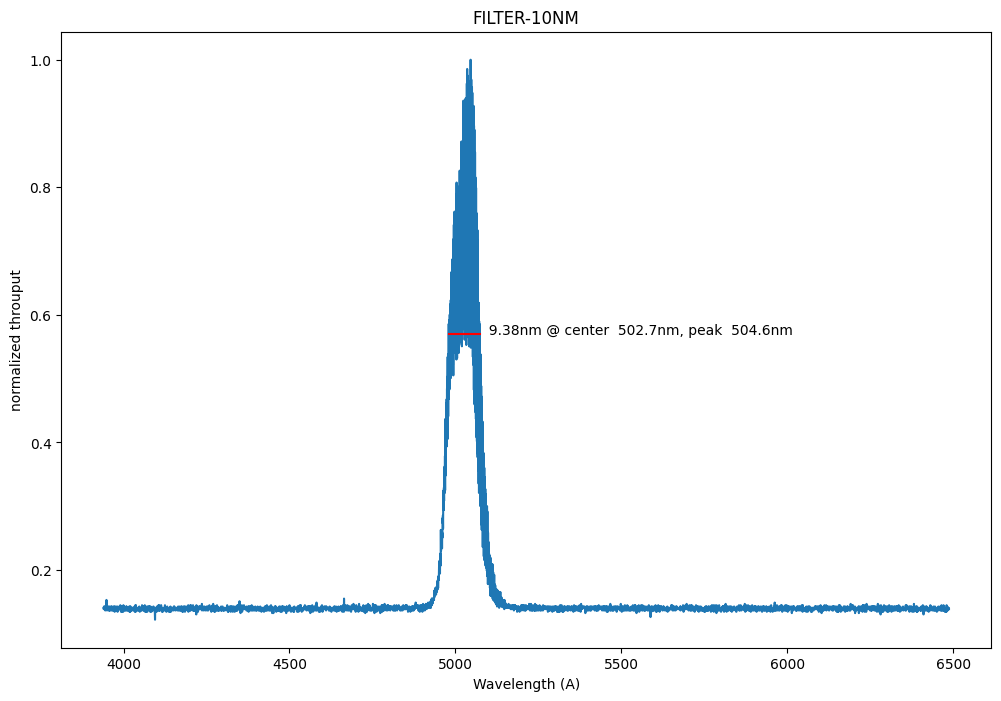

In [12]:

plt.rcParams['figure.figsize'] = (12,8)
fig, axes = plt.subplots()
plt.plot(waves,trace_n)
plt.plot([fwhm_wave_min,fwhm_wave_max],[half_intensity,half_intensity],color='red')
plt.xlabel('Wavelength (A)')
plt.ylabel('normalized throuput')
plt.title(filter_name)
plt.xlim = [waves[0], waves[-1]]
plt.ylim = [0,1]
plt.text(fwhm_wave_max,half_intensity,f'{width_nm:6.3}nm @ center{fwhm_wave_center/10:7.1f}nm, peak{wavelength_peak/10:7.1f}nm ')
plt.show()